In [12]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

In [13]:
T = 1./12
m = 4
K = 364.
r = 0.04
S0 = 361.24
sigma = 0.3
N = 10000
Q = 0

In [14]:
#time step 
dt = T / m

#stock path and Standard Brownian Motion initialization 
S = np.zeros((m + 1, N))
dB = np.zeros((m + 1, N))

# Initial Stock Value
S[0] = S0

#Forward generation (Cf computational finance books)
for t in range(1, m + 1):
    x = np.random.standard_normal(size=N)
    S[t] = S[t - 1] * np.exp((r - sigma ** 2 / 2) * dt
                             + sigma * np.sqrt(dt) * x)
    dB[t] = np.sqrt(dt) * x

# Set final payoff 
Y = np.maximum(S[-1] - K, 0)

# Input data at time 2W
X = S[1]

# For random Forest regression to work in One dimension
X = X[:, None]

C:\Users\Олександр\AppData\Local\Temp\ipykernel_20564\1387297218.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


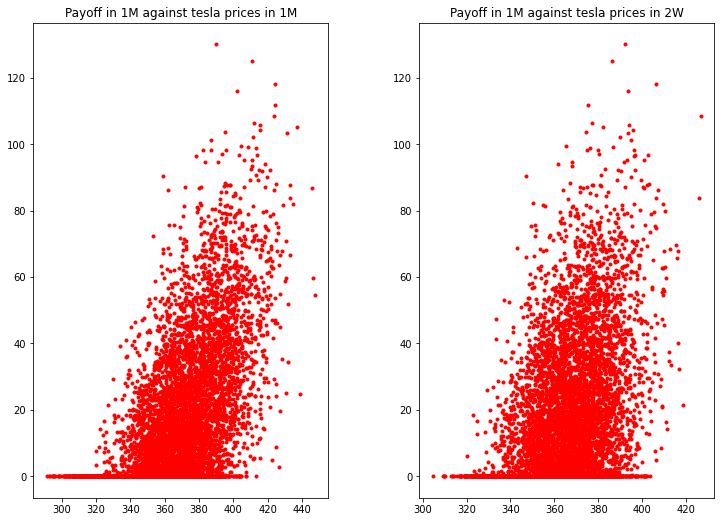

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
plt.tight_layout(pad=0.4, w_pad=6, h_pad=1.0)

ax1.plot(S[2], Y , 'r.')
ax2.plot(S[1], Y , 'r.')
ax1.set_title('Payoff in 1M against tesla prices in 1M')
ax2.set_title('Payoff in 1M against tesla prices in 2W')

f.show()

In [17]:
# Polynomial regression (degree = 5) 

reg1 = np.polyfit(S[1], Y, 5)
expected_Y_polynomial = np.polyval(reg1, S[1])

In [18]:
# Gaussian kernel regression using only nearest neighbors (for performance matters)
NN = kneighbors_graph(X.reshape(N, 1), int(N * 0.01), mode='distance').nonzero()
l = 2

x = NN[0]
y = NN[1]

# W is the weight matrix, i.e in w(i,j) = exp(-(x_j - x_i)^2 / 2.l^2) / sum_axis_0(exp(-(x_j - x_i)^2 / 2.l^2))
W = scipy.sparse.lil_matrix((N, N))
W[x, y] = np.exp(- (X[y] - X[x]) ** 2 / (2 * l ** 2))[0]

# As (i, i) not in NN, we add it manually
W.setdiag(np.ones(N))

# Sum over each row and update the weight
sum_weights = W.sum(axis=0)
W = W.dot(scipy.sparse.diags(np.array(1 / sum_weights)[0]))

# E[Y_(t+dt)_j|F_t] = f(X_j) = sum(w(i, j)*Y(i))
expected_Y_kernel = W.dot(Y)

Text(0.5, 1.0, 'Gaussian Kernel Regression')

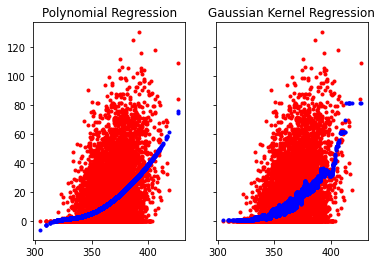

In [19]:
# add regression figure into a subplot
f2, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(S[1], Y , 'r.')
ax1.plot(S[1], expected_Y_polynomial , 'b.')

ax1.set_title('Polynomial Regression')

ax2.plot(S[1], Y , 'r.')
ax2.plot(S[1], expected_Y_kernel , 'b.')

ax2.set_title('Gaussian Kernel Regression')

In [20]:
#Define Random Forest Regressor 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [21]:
# Polynomial regression (degree = 5) 

reg1 = rf.fit(X, Y)
expected_Y_rf = rf.predict(X)

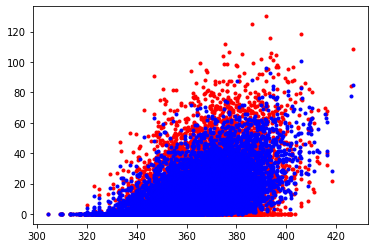

In [22]:
plt.plot(X, Y , 'r.')
plt.plot(X, expected_Y_rf, 'b.')

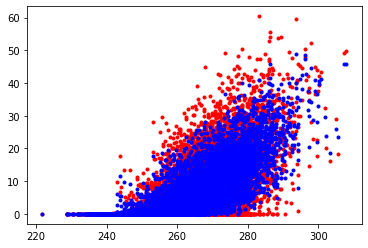